In [1]:
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt

### Define x_vector where y values will be sampled

In [2]:
npoints = 50
_x = np.linspace(-5, 5, npoints)

### Define kernel parameters, mean and kernel function

In [3]:
def mean_func(x_i):
    return 0

In [4]:
def kernel_func(x_i, x_j, sigma_l=1):
    return np.exp(-0.5 * ((x_i - x_j)/sigma_l) **2)

### Mean values and Kernel Matrix for x grid

In [54]:
# mean vector, K matrix for x_vector
_mean_i = np.empty(npoints)
_K = np.empty([npoints, npoints])
for i in range(npoints):
    _mean_i[i] = mean_func(_x[i])
    for j in range(npoints):
        _K[i,j] = kernel_func(_x[i], _x[j])

# K materix with different sigma length
sigma_l=3
_K2 = np.empty([npoints, npoints])
for i in range(npoints):
    for j in range(npoints):
        _K2[i,j] = kernel_func(_x[i], _x[j], sigma_l)

In [50]:
_mean_i.shape, _K.shape

((50,), (50, 50))

### Define GP based on mean and K matrix

In [51]:
n_prior_funcs = 10
priors = st.multivariate_normal.rvs(mean=_mean_i, cov=_K, size=n_prior_funcs)
priors2 = st.multivariate_normal.rvs(mean=_mean_i, cov=_K2, size=n_prior_funcs)

### Visualize GP Priors and effect of sigma_l

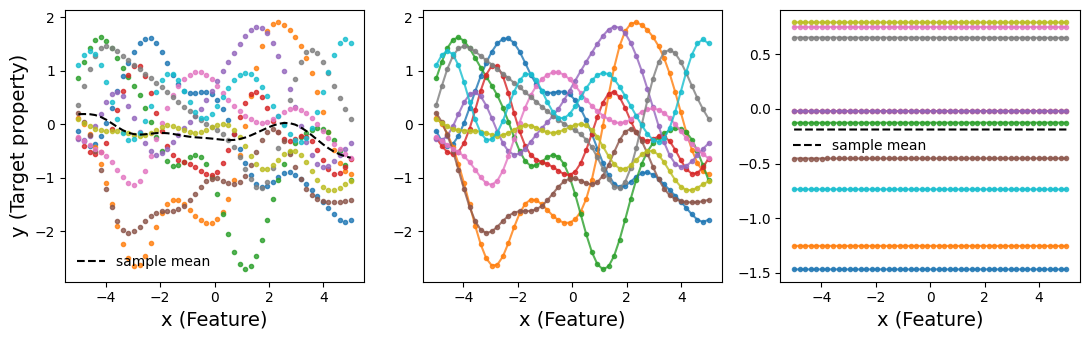

In [52]:
fig, (ax1,ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(11,3.5))

for idx in range(len(priors)):
    ax1.plot(_x, priors[idx], 'o', ms=3, alpha=0.8)
    ax2.plot(_x, priors[idx], '-o', ms=3, alpha=0.8)
    ax3.plot(_x, priors2[idx], '-o', ms=3, alpha=0.8)

ax1.plot(_x, np.mean(priors, axis=0), '--k', label='sample mean')  # Compute sample mean
ax3.plot(_x, np.mean(priors2, axis=0), '--k', label='sample mean')  # Compute sample mean

ax1.set_ylabel('y (Target property)', fontsize=14)
ax1.set_xlabel('x (Feature)', fontsize=14)
ax2.set_xlabel('x (Feature)', fontsize=14)
ax3.set_xlabel('x (Feature)', fontsize=14)

ax1.legend(frameon=False)
ax3.legend(frameon=False)

plt.tight_layout()

### Questions
1. We assumed mean function to be 0. Why is the sample mean at different values of x not exactly zero.

The dotted black line represents the mean of the sample but as observed from the plot it is not linear 0 plot but it deviates from 0 this is due to the the number of points we have considered there are 10 so the average may not reflect the true mean of the distribution. The process considered uncertainity. For this approah the main focus is the covariance which is responsible for the similarity of the inputs.



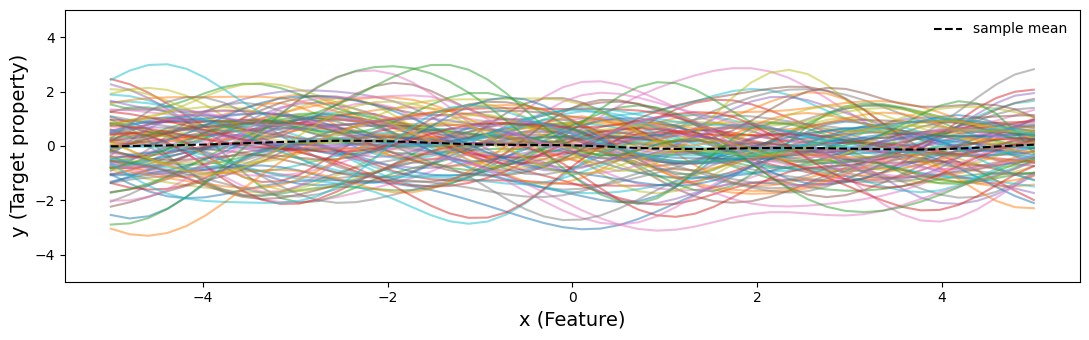

In [53]:
n_prior_funcs = 100
priors = st.multivariate_normal.rvs(mean=_mean_i, cov=_K, size=n_prior_funcs)

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(11,3.5))

for idx in range(len(priors)):
    ax1.plot(_x, priors[idx], '-', ms=3, alpha=0.5)

ax1.plot(_x, np.mean(priors, axis=0), '--k', label='sample mean')  # Compute sample mean

ax1.set_ylabel('y (Target property)', fontsize=14)
ax1.set_xlabel('x (Feature)', fontsize=14)

ax1.legend(frameon=False)

ax1.set_ylim(-5,5)

plt.tight_layout()

### Question
2. Why does most of the sampled functions are restricted to the y value being between (-2,2)?

The guassian kernal function decreases as the distance between both the points increases.when the parameter sigma_l is decreased, the kernal function decreases rapidly with the distance, that leads to constrained smaller range of y-values.

### Given (Training) Data; Observations

In [55]:
# Real given X, y data
y = np.array([6, 0, 0])
x = np.array([0, 1, 2])
x_star = np.array([3])  # Test point

### Make Prediction for complete x grid  (Noise free case)

In [23]:
n_train = len(y)
n_test = len(x_star)

K = np.empty((n_train, n_train))
for i in range(n_train):
    for j in range(n_train):
        K[i,j] = kernel_func(x[i], x[j])

K_star = np.empty((n_train, npoints))
for i in range(n_train):
    for j in range(npoints):
        K_star[i,j] = kernel_func(x[i], _x[j])

In [24]:
post_mean = K_star.T.dot(np.linalg.pinv(K)).dot(y)
post_var = _K - K_star.T.dot(np.linalg.pinv(K)).dot(K_star)
posteriors = st.multivariate_normal.rvs(mean=post_mean, cov=post_var, size=1000)

### Visualize posteriors / conditional probablities

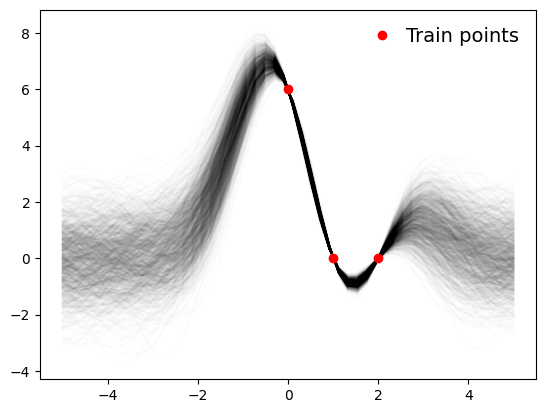

In [25]:
for i in range(1000):
    plt.plot(_x, posteriors[i], c='k', alpha=0.01)

plt.plot(x, y, 'ro', label='Train points')
plt.legend(frameon=False, fontsize=14, handletextpad=0.2)
plt.show()

### Question
3. Why does all the sampled posterior functions pass through the red dots?
4. Why most of the sampled posterior fuctions have y value between (-2,2) at x=4 and x=-4?

3. In guassian process regressio, the training data points influence the mean of the posterior distribution as a result of it the predicted function passes through the red dots which are the training examples. In this approach it leads to overfitting of the data in which the training error is minimum but the test is is more.This can be avoided by adding noise which is done in the further section of the code.

4. Due to the kernal function , if the kernal function decreases rapidly with distance then the influence of training data points on the predicted function values at distant test points decreases.which eventually leads to concentration of sampled function around the mean.

*   List item
*   List item


By the length scale parameter sigma_l of the kernal function. If the length scake is small, the function may have rapid variations which leads to concentration of y values within a specific range.

### Make Prediction for complete x grid  (Noise inclusive)

In [56]:
sigma_n = 0.3
K_noisy = K.copy()
for i in range(n_train):
        K_noisy[i,i] = K[i,i] + sigma_n**2

In [57]:
post_mean = K_star.T.dot(np.linalg.pinv(K_noisy)).dot(y)
post_var = _K - K_star.T.dot(np.linalg.pinv(K_noisy)).dot(K_star)
posteriors = st.multivariate_normal.rvs(mean=post_mean, cov=post_var, size=1000)

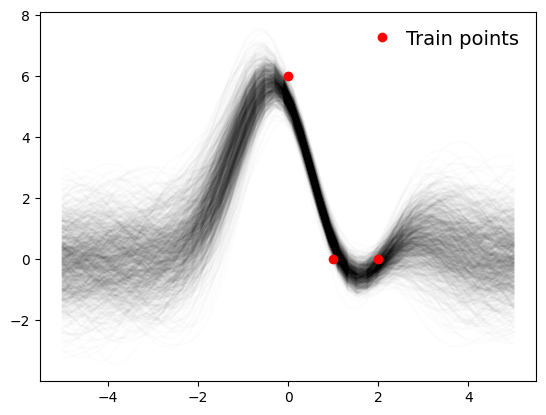

In [28]:
for i in range(1000):
    plt.plot(_x, posteriors[i], c='k', alpha=0.01)

plt.plot(x, y, 'ro', label='Train points')
plt.legend(frameon=False, fontsize=14, handletextpad=0.2)
plt.show()

### Question
5. Why does the sampled posterior functions do not perfectly pass through the observed training data in this case?

Adding noise to the covariance matrix helps to model uncertainity and variabilty in the training data, it does not lead to overfitting of the model.Therefore the training data points does not directly pass through the function as it generalize the pattern. It hrlpd in predicting more realistic and robust preedictions by acknowledging the uncertainity in the training data.